**Análisis de minería de texto para selección de encuestas**

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('peopleware.csv', sep=',') 

In [ ]:
data.head(443)

,id,created_add,name,screen_name,full_text
0,1,2022-09-13 9:00:00,Cuestionario de Litwin y Stringer,@litwinstringer,En esta empresa los trabajos están bien defini...
1,2,2022-09-13 9:00:00,Cuestionario de Litwin y Stringer,@litwinstringer,En esta empresa no siempre está claro quién de...
2,3,2022-09-13 9:00:00,Cuestionario de Litwin y Stringer,@litwinstringer,Esta empresa se preocupa de que yo tenga claro...
3,4,2022-09-13 9:00:00,Cuestionario de Litwin y Stringer,@litwinstringer,En esta empresa no es necesario permiso para h...
4,5,2022-09-13 9:00:00,Cuestionario de Litwin y Stringer,@litwinstringer,Las ideas nuevas no se toman mucho en cuenta. ...
...,...,...,...,...,...
379,429,2022-09-13 9:00:00,Gestión de los recursos humanos,@peopleware,Gestión de los recursos humanos:Justo al comie...
380,430,2022-09-13 9:00:00,La gente correcta,@peopleware,La gete correcta: Pasamos a la tercera parte d...
381,431,2022-09-13 9:00:00,Felicidad en el trabajo,@peopleware,Felicidad en el trabajo: Vamos con la quinta y...
382,432,2022-09-13 9:00:00,Crear equipos productivos,@peopleware,Creación de equipos productivos: Visitamos aho...


In [ ]:
# Se unen los dos dataframes en uno solo

# Se seleccionan y renombran las columnas de interés
tweets = data[['screen_name', 'created_add', 'id', 'full_text']]
tweets.columns = ['autor', 'fecha', 'id', 'texto']

# Parseo de fechas
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
tweets.head(3)

,autor,fecha,id,texto
0,@litwinstringer,2022-09-13 09:00:00,1,En esta empresa los trabajos están bien defini...
1,@litwinstringer,2022-09-13 09:00:00,2,En esta empresa no siempre está claro quién de...
2,@litwinstringer,2022-09-13 09:00:00,3,Esta empresa se preocupa de que yo tenga claro...


In [ ]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Excluye conectores comunes
    nuevo_texto = re.sub("el ", ' ', nuevo_texto)
    nuevo_texto = re.sub("de ", ' ', nuevo_texto)
    nuevo_texto = re.sub("para ", ' ', nuevo_texto)
    nuevo_texto = re.sub("la ", ' ', nuevo_texto)
    nuevo_texto = re.sub("las ", ' ', nuevo_texto)
    nuevo_texto = re.sub("los ", ' ', nuevo_texto)
    nuevo_texto = re.sub("con ", ' ', nuevo_texto)
    nuevo_texto = re.sub("se ", ' ', nuevo_texto)
    nuevo_texto = re.sub("que " , ' ', nuevo_texto)
    nuevo_texto = re.sub("se ", ' ', nuevo_texto)
    nuevo_texto = re.sub("en " , ' ', nuevo_texto)
    nuevo_texto = re.sub("sus " , ' ', nuevo_texto)
    nuevo_texto = re.sub("un " , ' ', nuevo_texto)
    nuevo_texto = re.sub("su " , ' ', nuevo_texto)
    nuevo_texto = re.sub("es " , ' ', nuevo_texto)
    nuevo_texto = re.sub("por " , ' ', nuevo_texto)
    nuevo_texto = re.sub("si " , ' ', nuevo_texto)
    nuevo_texto = re.sub("una " , ' ', nuevo_texto)
    nuevo_texto = re.sub("más " , ' ', nuevo_texto)
    nuevo_texto = re.sub("no " , ' ', nuevo_texto)
    nuevo_texto = re.sub("son " , ' ', nuevo_texto)
    nuevo_texto = re.sub("cómo " , ' ', nuevo_texto)
    nuevo_texto = re.sub("ha " , ' ', nuevo_texto)
    nuevo_texto = re.sub("me " , ' ', nuevo_texto)
    nuevo_texto = re.sub("mi " , ' ', nuevo_texto)
    nuevo_texto = re.sub("esta " , ' ', nuevo_texto)
    nuevo_texto = re.sub("nos " , ' ', nuevo_texto)
    nuevo_texto = re.sub("como " , ' ', nuevo_texto)
    nuevo_texto = re.sub("al " , ' ', nuevo_texto)
    nuevo_texto = re.sub("lo " , ' ', nuevo_texto)
    nuevo_texto = re.sub("usted " , ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [ ]:
test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining el de para las los con semantica"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining el de para las los con semantica
['esto', 'ejemp', 'limpieza', 'texto', 'cienciadedatos', 'textmining', 'semantica']


In [ ]:
# Se aplica la función de limpieza y tokenización a cada tweet
# ==============================================================================
tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,En esta empresa los trabajos están bien defini...,"[empresa, trabajos, están, bi, definidos, orga..."
1,En esta empresa no siempre está claro quién de...,"[empresa, siempre, está, claro, quién, debe, t..."
2,Esta empresa se preocupa de que yo tenga claro...,"[empresa, preocupa, yo, tenga, claro, funciona..."
3,En esta empresa no es necesario permiso para h...,"[empresa, necesario, permiso, hacer, cada, cosa]"
4,Las ideas nuevas no se toman mucho en cuenta. ...,"[ideas, nuevas, toman, mucho, cuenta, debido, ..."


In [ ]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,autor,fecha,id,token
0,@litwinstringer,2022-09-13 09:00:00,1,empresa
0,@litwinstringer,2022-09-13 09:00:00,1,trabajos
0,@litwinstringer,2022-09-13 09:00:00,1,están


In [ ]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por autor')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Palabras totales por autor
--------------------------


autor
@alvarezlondoño    276
@garcia             85
@likert            123
@litwinstringer    415
@maryrivas         292
@mendezi           278
@peopleware        844
@perezlopez        874
@sudarsky          594
@toro              175
Name: token, dtype: int64

In [ ]:
# Palabras distintas utilizadas por cada autor
# ==============================================================================
print('----------------------------')
print('Palabras distintas por autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Palabras distintas por autor
----------------------------


autor
@alvarezlondoño    200
@garcia             63
@likert             88
@litwinstringer    242
@maryrivas         174
@mendezi           171
@peopleware        571
@perezlopez        510
@sudarsky          313
@toro              123
Name: token, dtype: int64

In [ ]:
# Longitud media y desviación de los tweets de cada autor
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
@alvarezlondoño,11.500000,4.333891
@garcia,5.000000,2.121320
@likert,5.857143,1.904881
@litwinstringer,8.300000,2.549510
@maryrivas,7.300000,2.266817
@mendezi,6.465116,2.130826
@peopleware,168.800000,55.742264
@perezlopez,10.658537,3.689222
@sudarsky,6.600000,3.027217


In [ ]:
# Top 5 palabras más utilizadas por cada autor
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(3))

autor         token  count
autor                                                     
@alvarezlondoño 127   @alvarezlondoño  organización     14
                188   @alvarezlondoño       trabajo      7
                141   @alvarezlondoño      personas      7
@garcia         222           @garcia       empresa      5
                243           @garcia     objetivos      4
                215           @garcia     considera      4
@likert         285           @likert  departamento      7
                348           @likert       trabajo      5
                280           @likert   coordinador      4
@litwinstringer 428   @litwinstringer       empresa     43
                585   @litwinstringer       trabajo     16
                370   @litwinstringer            bi      7
@maryrivas      758        @maryrivas       trabajo     18
                641        @maryrivas       empresa     16
                746        @maryrivas        siento      9
@mendezi        919          @mendezi       trabajo     16
                814          @mendezi       empresa     13
                839          @mendezi          jefe     10
@peopleware     1465      @peopleware       trabajo     10
                1305      @peopleware         parte      9
                1116      @peopleware       equipos      9
@perezlopez     1703      @perezlopez       empresa     33
                1790      @perezlopez          jefe     27
                1988      @perezlopez       trabajo     14
@sudarsky       2314        @sudarsky       trabajo     37
                2160        @sudarsky         gente     17
                2165        @sudarsky         hacer     17
@toro           2392            @toro         grado     10
                2377            @toro       empresa      7
                2448            @toro       trabajo      7

In [ ]:
# Pivotado de datos
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [ ]:
tweets_pivot.head()

,@alvarezlondoño,@garcia,@likert,@litwinstringer,@maryrivas,@mendezi,@peopleware,@perezlopez,@sudarsky,@toro
token,,,,,,,,,,
acabamos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
accesible,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accident,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
accion,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
acción,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [ ]:
from pandas.core.dtypes.dtypes import Ordered
# Test de correlación (coseno) por el uso y frecuencia de palabras
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

from scipy.spatial import distance
def similitud_jaccard(a,b):
    distancia = distance.jaccard(a,b)
    return distancia

cor1 = tweets_pivot.corr(method=similitud_coseno)
cor2 = tweets_pivot.corr(method=similitud_jaccard)

In [ ]:
cor1

,@alvarezlondoño,@garcia,@likert,@litwinstringer,@maryrivas,@mendezi,@peopleware,@perezlopez,@sudarsky,@toro
@alvarezlondoño,1.000000,0.828998,0.629941,0.876060,0.822826,0.762245,0.676393,0.624136,0.566481,0.634855
@garcia,0.828998,1.000000,0.924250,0.849384,0.880135,0.767320,0.819181,0.653996,0.693026,0.900986
@likert,0.629941,0.924250,1.000000,0.850434,0.808835,0.796565,0.806469,0.738513,0.756981,0.861400
@litwinstringer,0.876060,0.849384,0.850434,1.000000,0.774602,0.738728,0.543736,0.816565,0.637778,0.805365
@maryrivas,0.822826,0.880135,0.808835,0.774602,1.000000,0.904463,0.752210,0.750314,0.847266,0.900764
@mendezi,0.762245,0.767320,0.796565,0.738728,0.904463,1.000000,0.765612,0.838698,0.799070,0.891807
@peopleware,0.676393,0.819181,0.806469,0.543736,0.752210,0.765612,1.000000,0.596776,0.739735,0.777386
@perezlopez,0.624136,0.653996,0.738513,0.816565,0.750314,0.838698,0.596776,1.000000,0.649917,0.729117
@sudarsky,0.566481,0.693026,0.756981,0.637778,0.847266,0.799070,0.739735,0.649917,1.000000,0.798573
@toro,0.634855,0.900986,0.861400,0.805365,0.900764,0.891807,0.777386,0.729117,0.798573,1.000000


In [ ]:
cor2

,@alvarezlondoño,@garcia,@likert,@litwinstringer,@maryrivas,@mendezi,@peopleware,@perezlopez,@sudarsky,@toro
@alvarezlondoño,1.000000,0.526316,0.615385,0.611111,0.531250,0.384615,0.522727,0.647059,0.608696,0.521739
@garcia,0.526316,1.000000,0.444444,0.846154,0.615385,0.777778,0.500000,0.633333,0.611111,0.615385
@likert,0.615385,0.444444,1.000000,0.620690,0.611111,0.529412,0.458333,0.675676,0.608696,0.750000
@litwinstringer,0.611111,0.846154,0.620690,1.000000,0.605263,0.558140,0.657534,0.706667,0.595506,0.722222
@maryrivas,0.531250,0.615385,0.611111,0.605263,1.000000,0.461538,0.574468,0.691176,0.605263,0.608696
@mendezi,0.384615,0.777778,0.529412,0.558140,0.461538,1.000000,0.600000,0.703125,0.725000,0.625000
@peopleware,0.522727,0.500000,0.458333,0.657534,0.574468,0.600000,1.000000,0.588235,0.585366,0.538462
@perezlopez,0.647059,0.633333,0.675676,0.706667,0.691176,0.703125,0.588235,1.000000,0.666667,0.837838
@sudarsky,0.608696,0.611111,0.608696,0.595506,0.605263,0.725000,0.585366,0.666667,1.000000,0.680000
@toro,0.521739,0.615385,0.750000,0.722222,0.608696,0.625000,0.538462,0.837838,0.680000,1.000000


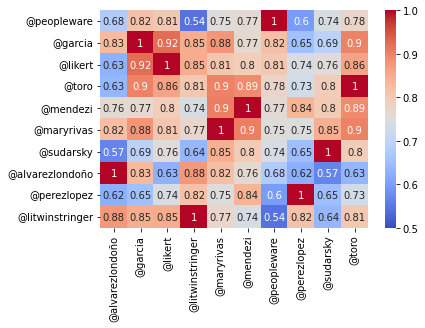

In [ ]:
sns.heatmap(cor1.sort_values(by=['@peopleware'],ascending=False), vmin = 0.5, vmax = +1, annot = True, cmap = 'coolwarm')

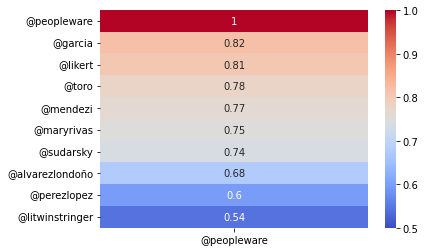

In [ ]:
df = cor1[['@peopleware']]
sns.heatmap(df.sort_values(by=['@peopleware'],ascending=False), vmin = 0.5, vmax = +1, annot = True, cmap = 'coolwarm')

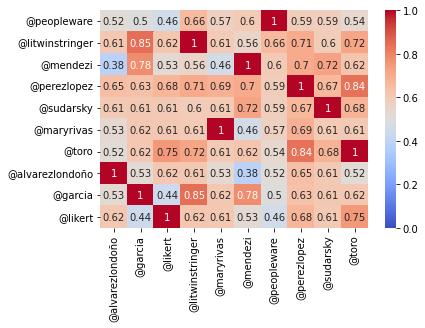

In [ ]:
sns.heatmap(cor2.sort_values(by=['@peopleware'],ascending=False), vmin = 0, vmax = +1, annot = True, cmap = 'coolwarm')

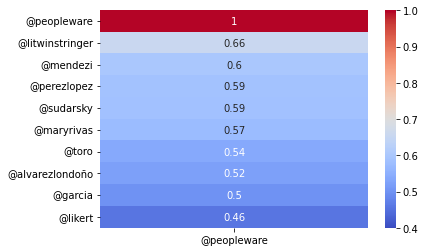

In [ ]:
df1 = cor2[['@peopleware']]
sns.heatmap(df1.sort_values(by=['@peopleware'],ascending=False), vmin = 0.4, vmax = +1, annot = True, cmap = 'coolwarm')